# SCI Dataset - Profiling

In [44]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from textwrap import wrap

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={"figure.figsize": (11.5, 8.5), "figure.dpi": 100})

from utils.data_profiling import band_proportions_periodic, sns_multi_time_series, topn_icd_in_year, sci_subset, median_los_per_band, missing_data, single_boxplot
from dataset import SCIData, SCICols

%load_ext autoreload
%autoreload 1
%aimport utils.data_profiling, dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
icd10 = pd.read_hdf('data/icd10.h5', 'ICD10_Codes')

In [95]:
sci = SCIData.load('data/sci.h5')#.derive_all()

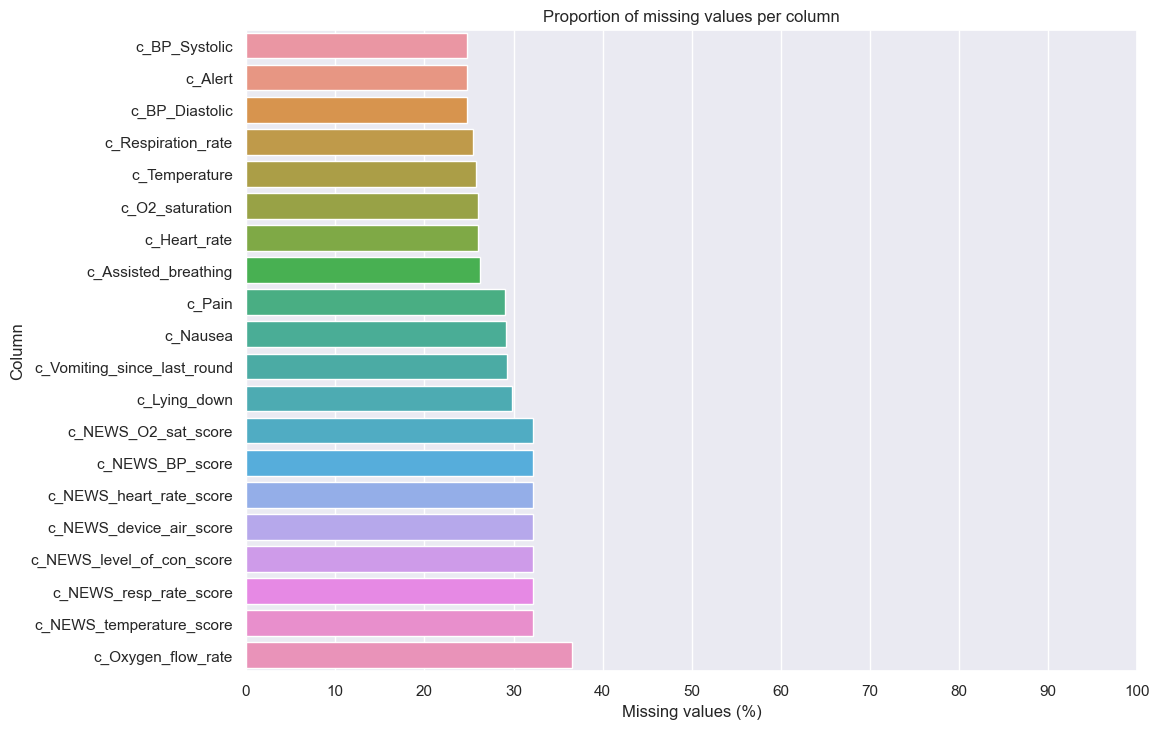

In [4]:
#fig, ax = plt.subplots(figsize=(10,15))
missing_data(sci, SCICols.news_data)

## NEWS Parameters

### O2 Saturation
We consider outliers to be values under `3` standard deviations of the mean, or any value >100 (as this is impossible). We correct outliers based on the recorded NEWS O2 saturation score. We set their value to the midpoint of the reference range for scores 0-2. For score = 3, we leave the value as-is.

The NEWS specification gives two reference scales [RCP17, pp.44]:
 - SpO2_1: By default.
 - SpO2_2: For patients with a prescribed oxygen saturation requirement of 88–92% (eg., in patients with hypercapnic respiratory failure).

We assume COPD (`J44.*` appearing in the patient's Diag codes) as triggering SpO2_2. If the patient is receiving oxygen, there is ambiguity as to whether a high O2 score means high or low saturation. In that case, we delete those values. SpO2_2 patients with score=0 will be assigned the midpoint of the range as normal.

A sizeable proportion of entries have an O2 saturation value but no score, or vice versa. We calculate the score for those given the scales in [RCP17]. 

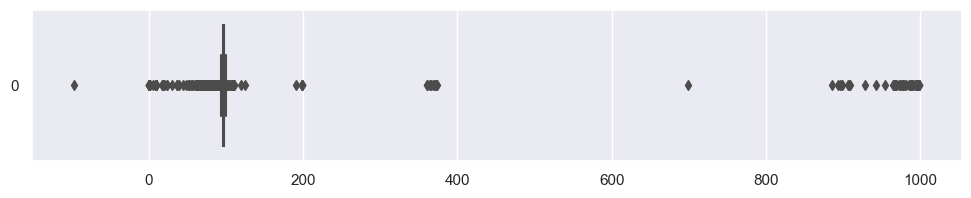

In [45]:
single_boxplot(sci, 'c_O2_saturation')

In [190]:
def clean_O2_saturation(df, outlier_threshold_std=3):
    sat, score = "c_O2_saturation", "c_NEWS_O2_sat_score"
    r = df.copy()

    # Assume negatives were erroneous and make them positive
    r.loc[r[sat] < 0, sat] *= -1

    # Assume zeros are dead
    r.loc[r[sat] == 0, sat] = np.nan

    # Assume single-digits were erroneous and shift to the left (e.g. 9.0 -> 90)
    r.loc[r[sat] <= 10, sat] *= 10

    # Set threshold for outliers to be under 3 std of the mean OR anything >100 (as it is impossible)
    threshold = r[sat].mean() - 3 * r[sat].std()
    outlier = (r[sat] > 100) | (r[sat] <= threshold)

    # Set criterion for SpO2_2 scale to be presence of COPD in the coded diagnoses
    copd = (
        r[SCICols.diagnoses]
        .isin(["J44.0", "J44.1", "J44.8", "J44.9", "J44.X"])
        .any(axis=1)
    )

    # Set outliers without copd and O2 Sat score < 3 to the midpoint of the corresponding score range
    mask1 = outlier & ~copd
    r.loc[mask1, sat] = np.nan

    # Set outliers with copd and O2 Sat score = 0 to 92
    mask2 = outlier & copd & (r[score] == 0)
    r.loc[mask2, sat] = 92

    # Delete the remaining outliers
    r.loc[outlier & copd & ~mask2, sat] = np.nan

    # Missing: Populate missing O2 saturation from score if available
    missing_sat_mask = r[sat].isna() & r[score].notna()
    missing_sat_scale1, missing_sat_scale2 = (
        ~copd & missing_sat_mask,
        copd & (r[score] == 0) & missing_sat_mask,
    )

    r.loc[missing_sat_scale1, sat] = r.loc[missing_sat_scale1, score].apply(
        SpO2_1_Scale_reverse
    )
    r.loc[missing_sat_scale2, sat] = 92

    # Missing: Populate missing O2 score from saturation if available
    missing_score_mask = r[sat].notna() & r[score].isna()
    missing_score_scale1, missing_score_scale2 = (
        ~copd & missing_score_mask,
        copd & missing_score_mask,
    )

    r.loc[missing_score_scale1, score] = r.loc[missing_score_scale1, sat].apply(
        SpO2_1_Scale
    )
    r.loc[missing_score_scale2, score] = r.loc[missing_score_scale2].apply(
        lambda row: SpO2_2_Scale(row[sat], row["c_Assisted_breathing"]), axis=1
    )

    return SCIData(r)


def SpO2_1_Scale_reverse(score):
    if score == 2:
        return 93
    elif score == 1:
        return 95
    elif score == 0:
        return 98
    elif score == 3:
        return np.nan


def SpO2_1_Scale(sat):
    if sat >= 96:
        return 0
    elif sat >= 94:
        return 1
    elif sat >= 92:
        return 2
    else:
        return 3


def SpO2_2_Scale(sat, assisted):
    if assisted:
        if sat >= 97:
            return 3
        elif sat >= 95:
            return 2
        elif sat >= 93:
            return 1
        elif sat >= 88:
            return 0
    if sat >= 93:
        return 0
    elif sat >= 86:
        return 1
    elif sat >= 84:
        return 2
    else:
        return 3


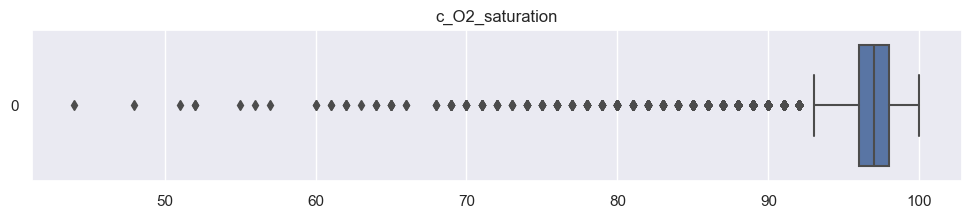

In [191]:
scii = clean_O2_saturation(sci)
single_boxplot(scii, 'c_O2_saturation')

### Blood Pressure

We apply criteria from [Fernandes20]. To be included, values must be:
 - Diastolic: Within $5 \leq d \leq 200$
 - Systolic: Within $20 \leq s \leq 300$ and it must hold $s \geq d+5$

As before, we fill missing systolic NEWS scores using the raw value where available. We infer missing systolic BP values from the score, if one is available and is not = 3, as a score of 3 is ambiguous.

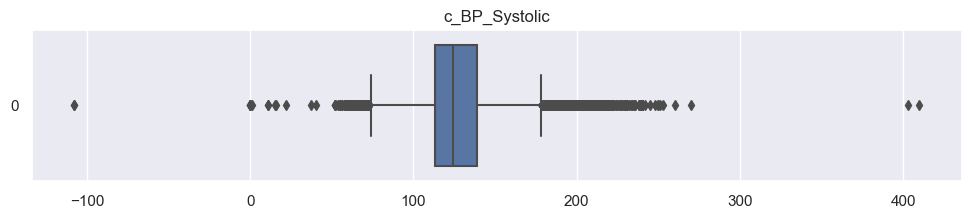

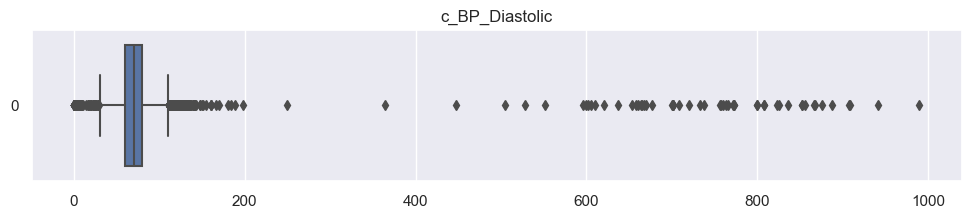

In [109]:
single_boxplot(sci, 'c_BP_Systolic')
single_boxplot(sci, 'c_BP_Diastolic')

In [183]:
def clean_blood_pressure(df, outlier_threshold_std=3):
    sys, dia, score = "c_BP_Systolic", "c_BP_Diastolic", "c_NEWS_BP_score"

    r = df.copy()
    for col in [sys, dia]:
        # Assume negatives were erroneous and make them positive
        r.loc[r[col] < 0, col] *= -1

    # Delete values outside cutoff range
    outlier_dia = (r[dia] <= 5) | (r[dia] >= 200)
    r.loc[outlier_dia, dia] = np.nan

    outlier_sys = (r[sys] <= 20) | (r[sys] >= 300) | (r[sys] <= r[dia] + 5)
    r.loc[outlier_sys, sys] = np.nan

    # Fill missing values using score and vice versa
    missing_score_mask, missing_sys_mask = (
        r[score].isna() & r[sys].notna(),
        r[score].notna() & r[sys].isna(),
    )

    r.loc[missing_sys_mask, sys] = r.loc[missing_sys_mask, score].apply(
        systolic_scale_reverse
    )
    r.loc[missing_score_mask, score] = r.loc[missing_score_mask, sys].apply(
        systolic_scale
    )

    return r


def systolic_scale(sys):
    if sys >= 220:
        return 3
    elif (sys <= 219) and (sys >= 111):
        return 0
    elif (sys <= 110) and (sys >= 101):
        return 1
    elif (sys <= 100) and (sys >= 91):
        return 2
    elif sys <= 90:
        return 3


def systolic_scale_reverse(score):
    if score == 2:
        return 95
    elif score == 1:
        return 105
    elif score == 0:
        return 165
    else:
        return np.nan


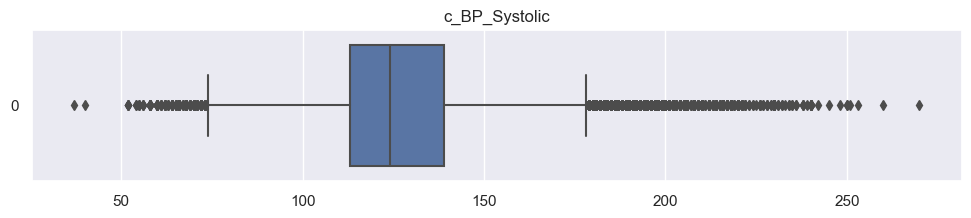

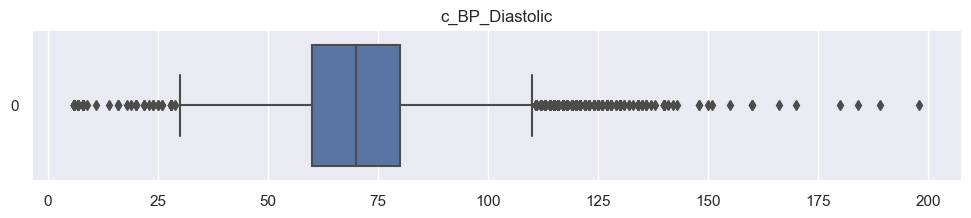

In [187]:
scii = clean_blood_pressure(sci)
single_boxplot(scii, 'c_BP_Systolic')
single_boxplot(scii, 'c_BP_Diastolic')

### Respiration Rate

We follow the previous methodology for supplementing scores and values. There are no clear guidelines on cutoff points for the respiration rate, as [Fernandes20] only excludes values $>80$. As an (outwardly) reasonable starting point we also exclude values $<5$. 

Triple-digit values such as 250 are assumed to mean 25. Negative values are inverted. 

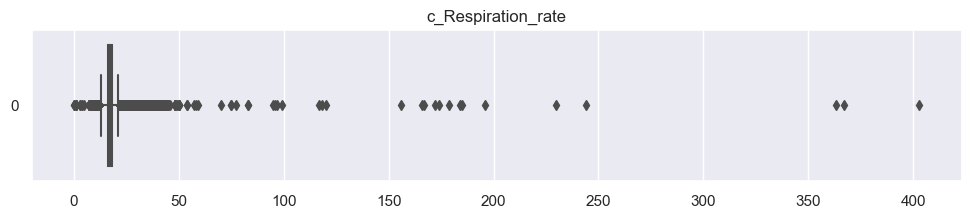

In [193]:
single_boxplot(sci, 'c_Respiration_rate')

In [235]:
def clean_respiration_rate(df):
    rate, score = 'c_Respiration_rate', 'c_NEWS_resp_rate_score'
    r = df.copy()

    # Assume negatives are erroneous and make them positive
    r.loc[r[rate] < 0, rate] *= -1

    # Assume triple digits are erroneous and shift them to the left
    r.loc[r[rate] >= 100, rate] //= 10

    outliers = (r[rate] >= 80) | (r[rate] <= 5)
    r.loc[outliers, rate] = np.nan

    missing_score_mask, missing_rate_mask = \
        r[score].isna() & r[rate].notna(), r[rate].isna() & r[score].notna()

    r.loc[missing_score_mask, score] = r.loc[missing_score_mask, rate].apply(respiration_scale)
    r.loc[missing_rate_mask, rate] = r.loc[missing_rate_mask, score].apply(respiration_scale_reverse)

    return SCIData(r)


def respiration_scale_reverse(score):
    if score == 1:
        return 10
    elif score == 2:
        return 23
    elif score == 0:
        return 16
    else:
        return np.nan

def respiration_scale(rate):
    if rate >= 25:
        return 3
    elif rate >= 21:
        return 2
    elif rate >= 12:
        return 0
    elif rate >= 9:
        return 1
    else:
        return 3

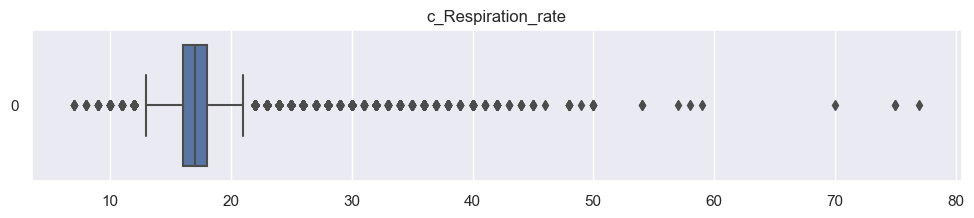

In [233]:
scii = clean_respiration_rate(sci)
single_boxplot(scii, 'c_Respiration_rate')

### Device Air

Just filling missing values between the score and value columns.

In [251]:
def clean_device_air(df):
    score, value = 'c_NEWS_device_air_score', 'c_Assisted_breathing'
    r = df.copy()

    # Some erroneous 1.0 values (impossible per the scale)
    r.loc[r[score] == 1.0, score] = np.nan

    missing_score_mask, missing_value_mask = \
        r[value].notna() & r[score].isna(), r[score].notna() & r[value].isna()

    r.loc[missing_score_mask, score] = r.loc[missing_score_mask, value].map({
        True: 2.0,
        False: 0.0
    })

    # Assume the score is more correct
    r[value] = r[score].map({
        2.0: True,
        0.0: False
    })

    return SCIData(r)

In [252]:
scii = clean_device_air(sci)

### Temperature

[Fernandes20] gives $20$ as the low-end cutoff for temperature. I increase this to $25$ as it seems more reasonable.

Within 3 std. is $35.22-38.30$

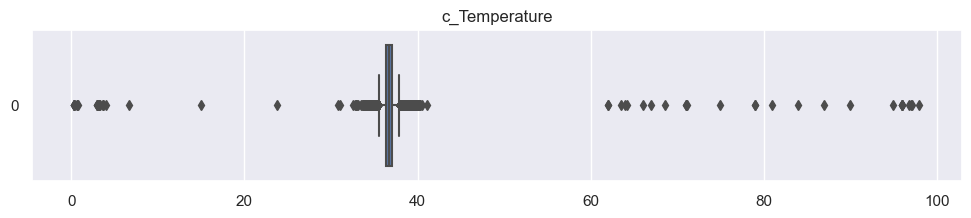

In [257]:
single_boxplot(sci, 'c_Temperature')

In [276]:
def clean_temperature(df):
    value, score = 'c_Temperature', 'c_NEWS_temperature_score'
    r = df.copy()

    r[r[value] < 0] *= 1
    
    outliers = (r[value] > 45) | (r[value] < 25)
    r.loc[outliers, value] = np.nan

    missing_value_mask, missing_score_mask = \
        r[value].isna() & r[score].notna(), r[score].isna() & r[value].notna()

    r.loc[missing_value_mask, value] = r.loc[missing_value_mask, score].apply(temperature_scale_reverse)
    r.loc[missing_score_mask, score] = r.loc[missing_score_mask, value].apply(temperature_scale)

    return SCIData(r)

def temperature_scale(temperature):
    if temperature >= 39.1:
        return 2
    elif temperature >= 38.1:
        return 1
    elif temperature >= 36.1:
        return 0
    elif temperature >= 35.1:
        return 1
    else:
        return 3

def temperature_scale_reverse(score):
    if score == 2:
        return 39.1
    elif score == 0:
        return 37.0
    elif score == 1:
        return 37.0
    elif score == 3:
        return 35.0

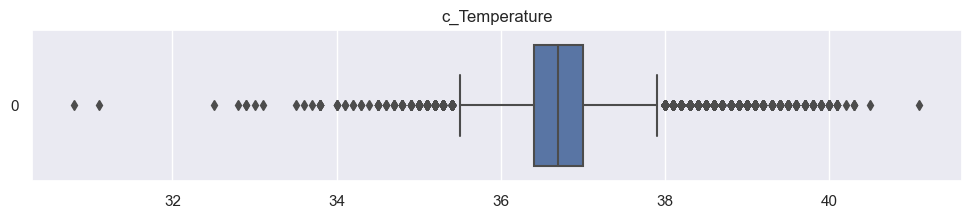

In [273]:
scii = clean_temperature(sci)
single_boxplot(scii, 'c_Temperature')

### Heart Rate

[Fernandes20] eliminates values over 300. Within 3 std is $34.47-127.3$.

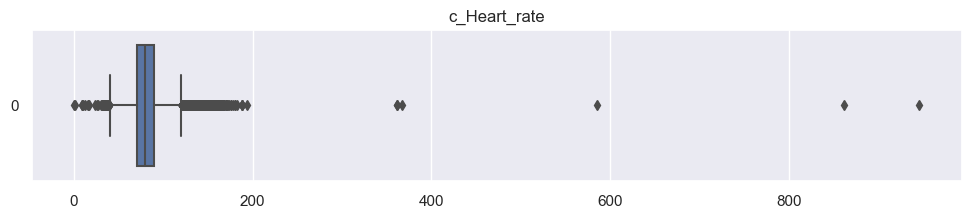

In [265]:
single_boxplot(sci, 'c_Heart_rate')

In [271]:
def clean_heart_rate(df):
    score, value = 'c_NEWS_heart_rate_score', 'c_Heart_rate'
    r = df.copy()
    
    r[r[value] < 0] *= 1

    outliers = (r[value] < 5) | (r[value] > 300)
    r.loc[outliers, value] = np.nan

    missing_value_mask, missing_score_mask = \
        r[value].isna() & r[score].notna(), r[score].isna() & r[value].notna()

    r.loc[missing_value_mask, value] = r.loc[missing_value_mask, score].apply(heartrate_scale_reverse)
    r.loc[missing_score_mask, score] = r.loc[missing_score_mask, value].apply(heartrate_scale)

    return SCIData(r)

def heartrate_scale(rate):
    if rate >= 131:
        return 3
    elif rate >= 111:
        return 2
    elif rate >= 91:
        return 1
    elif rate >= 51:
        return 0
    elif rate >= 41:
        return 1
    else: 
        return 3

def heartrate_scale_reverse(score):
    if score == 1:
        return 70
    elif score == 0:
        return 70
    elif score == 2:
        return 120
    else:
        return np.nan

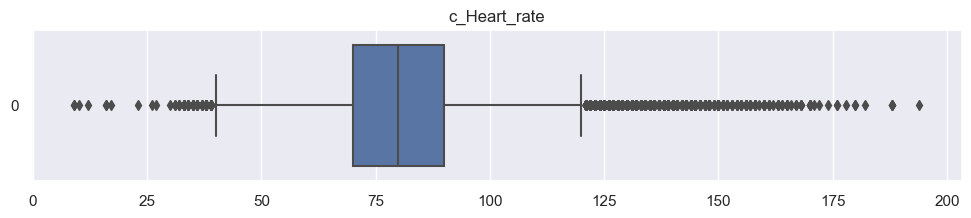

In [277]:
scii = clean_heart_rate(sci)
single_boxplot(scii, 'c_Heart_rate')

### Consciousness

This can be un-binarised to allow all options for CVPU. However, the number of samples is quite small.

In [285]:
def clean_consciousness(df):
    r = df.copy()

    score, value = 'c_NEWS_level_of_con_score', 'c_Alert'
    r = df.copy()

    # Some erroneous 1.0 values (impossible per the scale)
    r.loc[r[score] == 1.0, score] = np.nan

    missing_score_mask, missing_value_mask = \
        r[value].notna() & r[score].isna(), r[score].notna() & r[value].isna()

    r.loc[missing_score_mask, score] = r.loc[missing_score_mask, value].map({
        False: 3.0,
        True: 0.0
    })

    # Assume the score is more correct
    r[value] = r[score].map({
        3.0: False,
        0.0: True
    })

    return SCIData(r)

In [286]:
scii = clean_consciousness(sci)

### Oxygen Flow Rate

I am assuming this is measured in LPM (Litres Per Minute) as this fits with N - Nasal Cannula patients receiving 1.0-2.0 in most cases. 

If that is the case, values above 10 are unlikely so I'll assume they are erroneous and divide them by 10. 

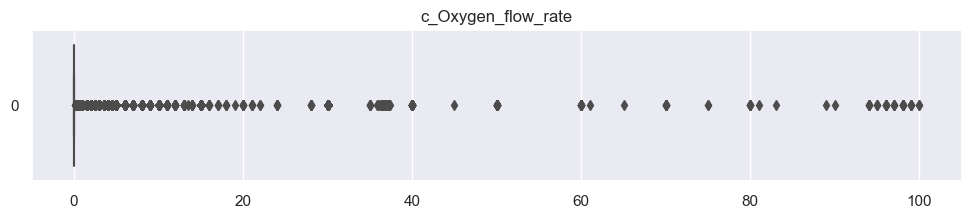

In [295]:
single_boxplot(sci, 'c_Oxygen_flow_rate')

In [296]:
def clean_O2_flow(df):
    col = 'c_Oxygen_flow_rate'
    r = df.copy()

    r.loc[r[col] > 10, col] /= 10

    return r

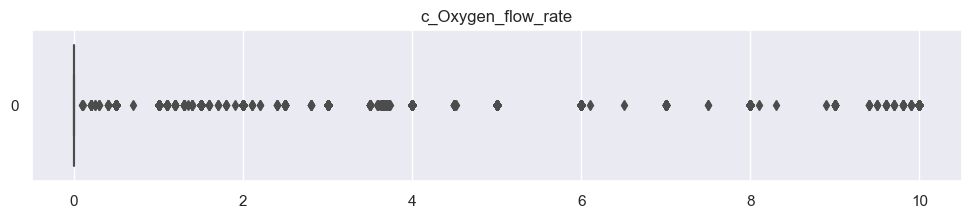

In [297]:
scii = clean_O2_flow(sci)
single_boxplot(scii, 'c_Oxygen_flow_rate')

### Lying Down

In [303]:
SCICols.vgb

['PatientTemperatureVenous',
 'pCO2(POC)Venous',
 'pCO2(Tempcorrected)(POC)Venous',
 'PH(POC)Venous',
 'PH(Tempcorrected)(POC)Venous',
 'pO2(POC)Venous',
 'pO2(Tempcorrected)(POC)Venous']

In [280]:
 'c_Oxygen_flow_rate', 'c_Lying_down',  'c_Pain',
 'c_Nausea',
 'c_Vomiting_since_last_round'

['c_Respiration_rate',
 'c_NEWS_resp_rate_score',
 'c_Assisted_breathing',
 'c_NEWS_device_air_score',
 'c_O2_saturation',
 'c_Oxygen_flow_rate',
 'c_NEWS_O2_sat_score',
 'c_Temperature',
 'c_NEWS_temperature_score',
 'c_Lying_down',
 'c_BP_Systolic',
 'c_BP_Diastolic',
 'c_NEWS_BP_score',
 'c_Heart_rate',
 'c_NEWS_heart_rate_score',
 'c_Alert',
 'c_NEWS_level_of_con_score',
 'c_Pain',
 'c_Nausea',
 'c_Vomiting_since_last_round']